# JAX assisted MAM Algorithm: Rotated Double Well

In [17]:
# Standard Package imports
import numpy as np
import numpy.linalg as la
import numpy.random as rm
from scipy.linalg import expm

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# MAM Code Imports
import sys
sys.path.append('/Users/cfn18/Documents/PhD-Work/Third-Year/Instanton-Work/Action-Minimisation-Algorithm/')

from fw_action_fps import *
from mam import *

# 2D Well Imports

sys.path.append('/rds/general/user/cfn18/home/Instantons/Rotated-2D-Well/Deterministic-Model')
# from fancyWell import *

import jax.numpy as jnp

# Problem Definition & Parameter Choices

Here we define the drift function of the 2D OU system and specify our parameter choices.

In [6]:
def grad_V(x):
    return jnp.array([x[0]*(x[0]**2 -1), 2 * x[1]])

In [7]:
def grad_V(x):
    return jnp.array([x[0]*(x[0]**2 -1), 2 * x[1]])

R = np.array([[0, -1], [1, 0]]) # 90 degree rotation matrix

def drift(x, s):
    alpha, eps = s
    return - jnp.matmul((jnp.eye(2) + alpha * R), grad_V(x))

def diff_inv(x, s):
    return Dinv

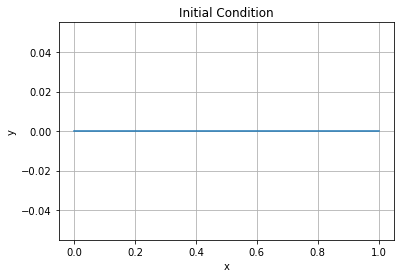

In [8]:
# Parameters
alpha = 0.

sigma = 1.e-4
r = 1.
D = np.zeros((2, 2))
D[0, 0] = 1
D[1, 1] = r**2
Dinv = la.inv(D)

p = np.array([alpha, sigma])

# Time
steps = 200
dt = 0.1
time = np.arange(0, dt * steps, dt)

# Initial Path
initial_point = [1, 0]
final_point = [0, 0]
inst_ic  = np.linspace(initial_point, final_point, steps)

plt.plot(inst_ic[:, 0], inst_ic[:, 1]) # Path whose action we calculate
plt.title('Initial Condition')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [9]:
diff_inv(1, 1)

array([[1., 0.],
       [0., 1.]])

## Effect of $\alpha$ on minimiser

Takes like 15 mins to run

In [10]:
fw = JFW(drift, diff_inv) # Freidlin-Wentzell object

In [ ]:
## Running MAM for Different Alpha Values

alphas = [0., 0.25, 0.5, 1.]
block_len = 1000
results = []

for a in tqdm(alphas):
    # Setup Problem
    p = [a, sigma]
    fw = JFW(drift, diff_inv) # Freidlin-Wentzell object
    mamjax = MamJax(fw, inst_ic, time, p)
    print(mamjax.p)
    opt={'maxiter': block_len, 'maxfun': block_len}
    mamjax.run(opt)
    print(mamjax.res.message)
    results.append((a, mamjax.instanton))

  0%|          | 0/4 [00:00<?, ?it/s]

[0.0, 0.0001]
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[0.25, 0.0001]
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[0.5, 0.0001]
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[1.0, 0.0001]


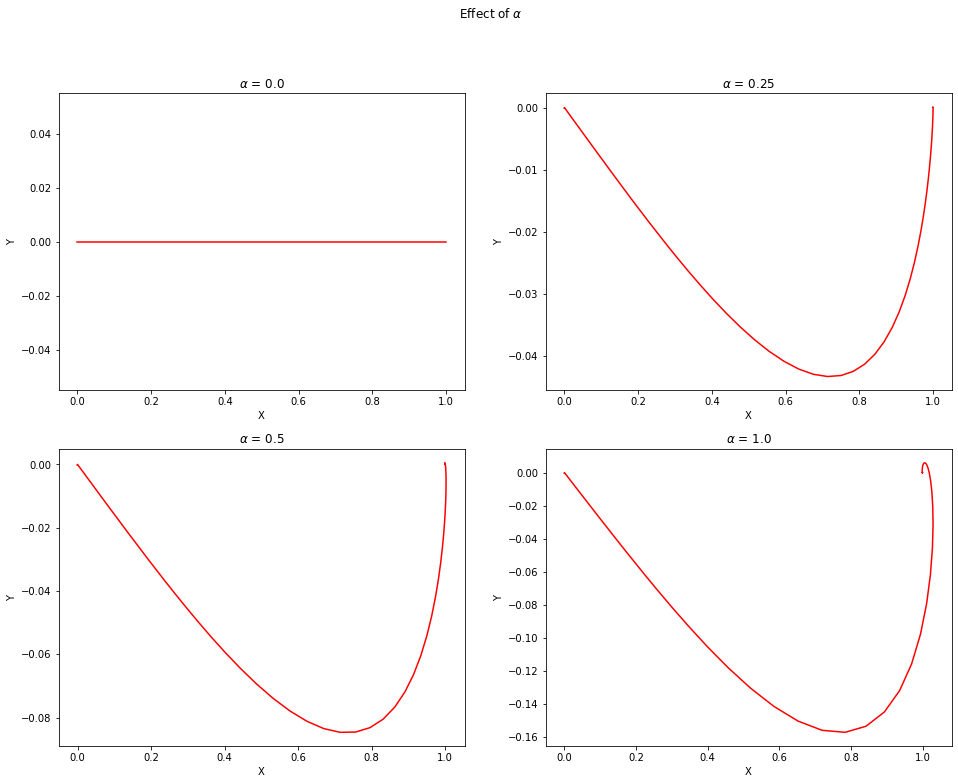

In [7]:
# Plotting Instantons

fig, axes = plt.subplots(2, 2, figsize = (16, 12))

for (res, ax) in zip(results, axes.flatten()):
    
    alpha, instanton = res
    
    ax.plot(instanton[:, 0], instanton[:, 1], 'r', label='Minimiser')
           
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'$\\alpha$ = {alpha}')
#     ax.set_xlim((-2, 2))
#     ax.set_ylim((-4, 4))



fig.suptitle('Effect of $\\alpha$')
fig.show()

## Saving Minimisation Results

In [8]:
import pickle

In [9]:
for r in results:
    alpha, instanton = r
    
    experiment = {'alpha': alpha,
                  'instanton': instanton,
                  'time': time,
                  'D': D
    }
    save_name = f'Data/varying-alpha/hot-to-saddle/alpha_{alpha:.2f}'.replace('.', '_') + '.pickle'
    print(save_name)
    with open(save_name, 'wb') as file:
        pickle.dump(experiment, file)

Data/varying-alpha/hot-to-saddle/alpha_0_00.pickle
Data/varying-alpha/hot-to-saddle/alpha_0_25.pickle
Data/varying-alpha/hot-to-saddle/alpha_0_50.pickle
Data/varying-alpha/hot-to-saddle/alpha_1_00.pickle


## Loading Minimisation Results

In [10]:
import os

In [11]:
alpha_experiment = []
data_dir = 'Minimisation/Data/varying-alpha/'
for s in os.listdir(data_dir):
    with open(data_dir + s, 'rb') as file:
        alpha_experiment.append(pickle.load(file))
        
for x in alpha_experiment:
    instanton = x['instanton']
    plt.plot(instanton[:, 0], instanton[:, 1])

FileNotFoundError: [Errno 2] No such file or directory: 'Minimisation/Data/varying-alpha/'

## Plotting Results

In [ ]:
import matplotlib.cm as cm 

In [ ]:
# Function for Streamfield background

def fancy_well_background(alpha, ax):
    
    # Plot Misc
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1, 1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    
    # alpha label
    ax.text(-1.2, 0.8, fr'$\alpha = {alpha:.2f}$', fontsize=15, bbox={'facecolor': '1', 'pad': 10}) #

    # Gradient Arrows
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    vx = X*(X**2 - 1) - 2 * alpha * Y 
    vy = alpha *X*(X**2 - 1) + 2 * Y 
    speed = np.sqrt(vx**2 + vy**2)
    ax.streamplot(x, y, -vx, -vy, color='1')
    ax.pcolormesh(X, Y, speed, cmap = 'Blues') 
    
    # Fixed Points
    cold_point = plt.Circle((-1, 0), 0.05, color='r')
    hot_point = plt.Circle((1, 0), 0.05, color='r')
    mid_point = plt.Circle((0, 0), 0.05, color='g')
    ax.add_patch(cold_point)
    ax.add_patch(hot_point)
    ax.add_patch(mid_point)
    return ax




In [ ]:
# Heteroclinic orbit vs. Minimiser Plot

fig, axes = plt.subplots(2, 2, figsize = (16, 16))

alphas = [0., 0.25, 0.5, 1.]

# Plot Streamfield and markers

for a, ax in zip(alphas, axes.flatten()):
    fancy_well_background(a, ax)


# Plot Relaxations

for a, ax in zip(alphas, axes.flatten()):

    runner = FancyWellIntegrator(a)
    saddle = np.zeros(2)
    
    # Cold Relaxation
    runner.state = saddle - np.array([1.e-3, 0])
    looker = TrajectoryObserver(runner)
    make_observations(runner, looker, 100, 0.1)
    cold_relaxation = looker.observations
    
    # Hot Relaxation
    runner.state = saddle + np.array([1.e-3, 0])
    looker = TrajectoryObserver(runner)
    make_observations(runner, looker, 100, 0.1)
    hot_relaxation = looker.observations
    
    arrow_points = slice(50, 60, 5)
    
    ax.plot(cold_relaxation.x, cold_relaxation.y, 'r--', lw=2, label ='Het. Orbit')
#     ax.plot(cold_relaxation.x[arrow_points], cold_relaxation.y[arrow_points], 'r<', lw=2)
    ax.plot(hot_relaxation.x, hot_relaxation.y, 'r--', lw=2)
#     ax.plot(hot_relaxation.x[arrow_points], hot_relaxation.y[arrow_points], 'r>', lw=2)

    
# Plot Instantons

# cold_to_saddle

for res, ax in zip(results, axes.flatten()):
    alpha, instanton = res
    ax.plot(instanton[:, 0], instanton[:, 1], 'r', lw=2, label='Minimiser')
    ax.plot(instanton[:, 0], instanton[:, 1], 'r', lw=2)
    ax.legend()


title_string = "Effect of $\\alpha$ on FW Minimiser and Hetroclinic Orbit"
subtitle_string = "$\\dot{x} = - (I + \\alpha R)\\nabla V$\n $V(x, y) = \\frac{1}{4} (x^2 -1)^2 + y^2$"

fig.text(0.4,.91, subtitle_string, fontsize=15, bbox={'facecolor': '1', 'pad': 10}) #
fig.suptitle(title_string, fontsize=18)

# fig.savefig('alpha-effect.pdf')

## Checking it minimises the FW Action

In [ ]:
instanton_action = action(jax_instanton)
print(f'Instanton Action value is {instanton_action:.3e}')

In [ ]:
def random_path(path, b):
    """Takes path and adds a random number to each point.
    For each point on the path an number is sampled from uniform(-b, b)
    and added to that point.
    """
    return path + rm.uniform(-b, b, path.shape)

In [ ]:
# Make many perturbed paths and compare the action

eps = 1.e-2 # how strongly we perturb instanton

nearby_paths = [random_path(jax_instanton, eps) for i in range(1000)]
nearby_actions = [action(x) for x in tqdm(nearby_paths)]

In [ ]:
action(analytic_solution[:, :2])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.grid()
count, edges, patch = ax.hist(nearby_actions, bins=50)
ax.plot(np.full_like(np.linspace(0, 1), instanton_action), np.linspace(0, 0.9*max(count)), '--', lw='4', label='Instanton Value')
ax.legend()
ax.set_title(f'Histogram of Actions for Nearby Paths, $\\epsilon =$ {eps}')
ax.set_xlabel('Action')
ax.set_ylabel('Count')
fig.show()

In [ ]:
v0(analytic_solution[:2, :2])

In [ ]:
b(analytic_solution[:, :2])

In [9]:
import jax.numpy as jnp

In [11]:
jnp.eye(2, 2)

DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32)